In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


devNumber = torch.cuda.current_device()
devName = torch.cuda.get_device_name(devNumber)
print(f"Using device: {device}")
print(f"Current device number is: {devNumber}")
print(f"GPU name is: {devName}")


Using device: cuda
Current device number is: 0
GPU name is: NVIDIA GeForce RTX 4070 SUPER


In [ ]:
#RNN-CharDataset.py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

# Sample text
text = "This is a simple example to demonstrate how to predict the next character using RNN in PyTorch."

# Creating character vocabulary
# part of the data preprocessing step for a character-level text modeling task. 
# Create mappings between characters in the text and numerical indices

#set(text): Creates a set of unique characters found in the text. The set function removes any duplicate characters.
#list(set(text)): Converts the set back into a list so that it can be sorted. 
# sorted(list(set(text))): Sorts the list of unique characters. 
chars = sorted(list(set(text)))
#This line creates a dictionary that maps each character to a unique index (integer)."
ix_to_char = {i: ch for i, ch in enumerate(chars)}
#Similar to the previous line, but in reverse. This line creates a dictionary that maps each unique index (integer) back to its corresponding character.
char_to_ix = {ch: i for i, ch in enumerate(chars)} 
chars = sorted(list(set(text)))




# Preparing the dataset
max_length = 10  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Defining the RNN model
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        #This line takes the input tensor x, which contains indices of characters, and passes it through an embedding layer (self.embedding). 
        #The embedding layer converts these indices into dense vectors of fixed size. 
        #These vectors are learned during training and can capture semantic similarities between characters. 
        #The result is a higher-dimensional representation of the input sequence, where each character index is replaced by its corresponding embedding vector. 
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        #The RNN layer returns two outputs: 
        #1- the output tensor containing the output of the RNN at each time step for each sequence in the batch, 
        #2-the hidden state (_) of the last time step (which is not used in this line, hence the underscore).
        output, _ = self.rnn(embedded)
        #The RNN's output contains the outputs for every time step, 
        #but for this task, we're only interested in the output of the last time step because we're predicting the next character after the sequence. 
        #output[:, -1, :] selects the last time step's output for every sequence in the batch (-1 indexes the last item in Python).
        output = self.fc(output[:, -1, :])  # Get the output of the last RNN cell
        return output

# Hyperparameters
hidden_size = 128
learning_rate = 0.005
epochs = 100

# Model, loss, and optimizer
model = CharRNN(len(chars), hidden_size, len(chars))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        #The use of the underscore _ is a common Python convention to indicate that the actual maximum values returned by torch.max are not needed and can be disregarded. 
        #What we are interested in is the indices of these maximum values, which are captured by the variable predicted. These indices represent the model's predictions for each example in the validation set.
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This is a simple example to demonstrate how to predict the next char"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

Epoch 10, Loss: 1.1191805601119995, Validation Loss: 4.314944267272949, Validation Accuracy: 0.0
Epoch 20, Loss: 0.11948591470718384, Validation Loss: 5.787036895751953, Validation Accuracy: 0.0
Epoch 30, Loss: 0.016859928146004677, Validation Loss: 6.836635112762451, Validation Accuracy: 0.0
Epoch 40, Loss: 0.0055493200197815895, Validation Loss: 7.276177883148193, Validation Accuracy: 0.0
Epoch 50, Loss: 0.003058017697185278, Validation Loss: 7.546679496765137, Validation Accuracy: 0.0
Epoch 60, Loss: 0.002195171546190977, Validation Loss: 7.704020977020264, Validation Accuracy: 0.0
Epoch 70, Loss: 0.0017832539742812514, Validation Loss: 7.779398441314697, Validation Accuracy: 0.0
Epoch 80, Loss: 0.001538213575258851, Validation Loss: 7.827261447906494, Validation Accuracy: 0.0
Epoch 90, Loss: 0.0013658790849149227, Validation Loss: 7.871212005615234, Validation Accuracy: 0.0
Epoch 100, Loss: 0.0012311636237427592, Validation Loss: 7.907532691955566, Validation Accuracy: 0.0
Predicte

Epoch 0, Loss: 0.004374136216938496
Epoch 10, Loss: 0.001906449324451387
Epoch 20, Loss: 0.0009492927347309887
Epoch 30, Loss: 0.00037736669764854014
Epoch 40, Loss: 0.00011446166899986565
Epoch 50, Loss: 4.0088689274853095e-05
Epoch 60, Loss: 2.3036775019136257e-05
Epoch 70, Loss: 1.8678072592592798e-05
Epoch 80, Loss: 1.7284173736697994e-05
Epoch 90, Loss: 1.6667787349433638e-05


Text(0.5, 1.0, 'Sine Wave Prediction')

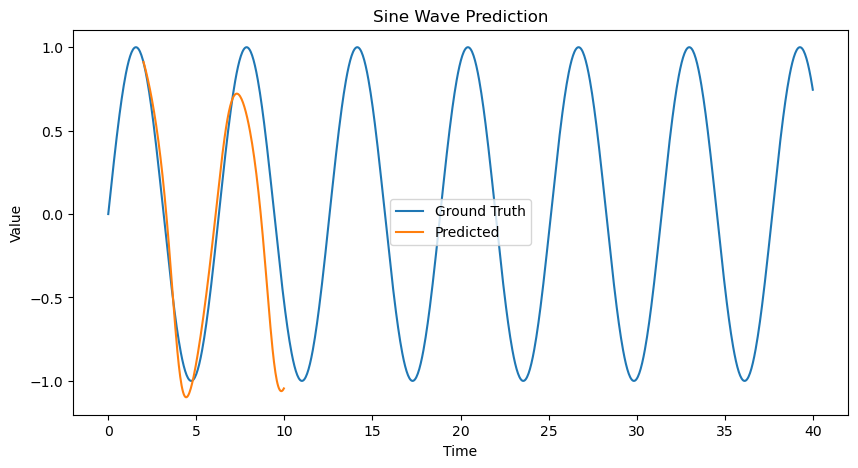

In [3]:
#RNN
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt



# Check for CUDA support and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate a sine wave dataset
timesteps = 1000   # Total timesteps
time = np.linspace(0, 40, timesteps)  # Time variable
data = np.sin(time)  # Sine wave dataset

# Convert data to PyTorch tensors and move to the selected device (GPU or CPU)
data = torch.FloatTensor(data).view(-1, 1).to(device)

# Define a simple RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)  # RNN layer
        self.fc = nn.Linear(hidden_size, output_size)  # Linear layer for output

    def forward(self, x):
        #The RNN layer returns two outputs: 
        #1- the output tensor containing the output of the RNN at each time step for each sequence in the batch, 
        #2-the hidden state (_) of the last time step (which is not used in this line, hence the underscore).
        out, _ = self.rnn(x)  # Process input through RNN
        #The RNN's output contains the outputs for every time step, 
        #but for this task, we're only interested in the output of the last time step because we're predicting the next character after the sequence. 
        #output[:, -1, :] selects the last time step's output for every sequence in the batch (-1 indexes the last item in Python).
        out = self.fc(out[:, -1, :])  # Pass the last time step output to linear layer
        return out

# Model parameters
input_size = 1
hidden_size = 100
output_size = 1

# Instantiate the model and move it to the selected device
model = RNNModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # Optimizer

# Prepare data for training by creating input-output sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 50  # Length of the sequence of data points considered for prediction
train_data = create_inout_sequences(data, seq_length)

# Training loop
epochs = 100
for epoch in range(epochs):
    for seq, labels in train_data:
        optimizer.zero_grad()
        seq = seq.view(1, seq_length, -1).to(device)  # Ensure data is on the same device as model
        labels = labels.to(device)  # Move labels to device
        y_pred = model(seq)  # Forward pass
        loss = criterion(y_pred, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Predict future values
with torch.no_grad():
    test_seq = data[:seq_length].view(1, seq_length, -1).to(device)  # Prepare initial sequence for prediction
    preds = []
    for _ in range(200):
        y_test_pred = model(test_seq)
        preds.append(y_test_pred.item())
        new_seq = test_seq[:, 1:, :]
        test_seq = torch.cat((new_seq, y_test_pred.view(1, 1, 1)), 1)

# Move predictions and original data back to CPU for plotting
preds = torch.tensor(preds).view(-1, 1).cpu()
data = data.cpu()

# Plot the results and save the plot
plt.figure(figsize=(10,5))
plt.plot(time, data.numpy().flatten(), label='Ground Truth')  # Plot the full ground truth sine wave
plt.plot(time[seq_length:seq_length+200], preds.numpy().flatten(), label='Predicted')  # Plot the predicted values
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Sine Wave Prediction')


In [ ]:
#shakespeare-loader
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Now `train_loader` and `test_loader` are ready to be used in a training loop